# Random Forest from scratch!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from pandas.api.types import is_string_dtype
import pyarrow
import numpy as np
from sklearn.tree import export_graphviz
import IPython, graphviz
from sklearn.ensemble import forest

/Users/bablu/Documents/Anaconda_Installation/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load in our data from last lesson

In [3]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()
            
def apply_cats(df, trn):
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [4]:
df_raw = pd.read_feather('tmp/raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [6]:
x_sub = X_train[['YearMade', 'MachineHoursCurrentMeter']]

## Basic data structures

In [7]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[rnd_idxs], self.y[rnd_idxs], min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

In [8]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf

In [9]:
m = TreeEnsemble(X_train, y_train, n_trees=10, sample_sz=1000, min_leaf=3)

In [10]:
m.trees[0]

In [11]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    # This just does one decision; we'll make it recursive later
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
            
    # We'll write this later!
    def find_better_split(self, var_idx): pass
    
    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

In [12]:
m = TreeEnsemble(X_train, y_train, n_trees=10, sample_sz=1000, min_leaf=3)

In [13]:
m.trees[0]

n: 1000; val:10.079014121552744

In [14]:
m.trees[0].idxs

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

## Single branch

### Find best split given variable

In [15]:
ens = TreeEnsemble(x_sub, y_train, 1, 1000)
tree = ens.trees[0]
x_samp,y_samp = tree.x, tree.y
x_samp.columns

Index(['YearMade', 'MachineHoursCurrentMeter'], dtype='object')

In [16]:
tree

n: 1000; val:10.079014121552744

In [17]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

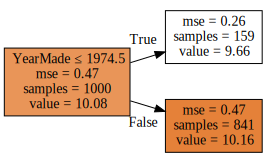

In [18]:
m = RandomForestRegressor(n_estimators=1, max_depth=1, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2)

In [19]:
def find_better_split(self, var_idx):
    x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]

    for i in range(1,self.n-1):
        lhs = x<=x[i]
        rhs = x>x[i]
        if rhs.sum()==0: continue
        lhs_std = y[lhs].std()
        rhs_std = y[rhs].std()
        curr_score = lhs_std*lhs.sum() + rhs_std*rhs.sum()
        if curr_score<self.score: 
            self.var_idx,self.score,self.split = var_idx,curr_score,x[i]

In [20]:
%timeit find_better_split(tree,1)
tree

68.2 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


n: 1000; val:10.079014121552744; score:681.0184057251435; split:3744.0; var:MachineHoursCurrentMeter

In [21]:
find_better_split(tree,0); tree

n: 1000; val:10.079014121552744; score:658.5510186055949; split:1974.0; var:YearMade

### Speeding things up

In [22]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]

In [23]:
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

def find_better_split_foo(self, var_idx):
    x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
    
    sort_idx = np.argsort(x)
    sort_y,sort_x = y[sort_idx], x[sort_idx]
    rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
    lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

    for i in range(0,self.n-self.min_leaf-1):
        xi,yi = sort_x[i],sort_y[i]
        lhs_cnt += 1; rhs_cnt -= 1
        lhs_sum += yi; rhs_sum -= yi
        lhs_sum2 += yi**2; rhs_sum2 -= yi**2
        if i<self.min_leaf or xi==sort_x[i+1]:
            continue
            
        lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
        rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
        curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
        if curr_score<self.score: 
            self.var_idx,self.score,self.split = var_idx,curr_score,xi

In [24]:
%timeit find_better_split_foo(tree,1)
tree

2.35 ms ± 360 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


n: 1000; val:10.079014121552744; score:681.0184057251353; split:3744.0; var:MachineHoursCurrentMeter

In [25]:
find_better_split_foo(tree,0); tree

n: 1000; val:10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

In [26]:
DecisionTree.find_better_split = find_better_split

In [27]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]; tree

n: 1000; val:10.079014121552744; score:658.5510186055949; split:1974.0; var:YearMade

## Full single tree

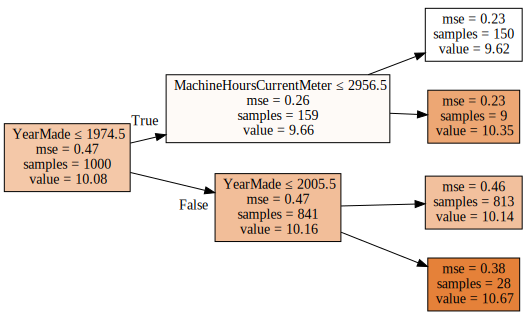

In [28]:
m = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2)

In [29]:
def find_varsplit(self):
    for i in range(self.c): self.find_better_split(i)
    if self.is_leaf: return
    x = self.split_col
    lhs = np.nonzero(x<=self.split)[0]
    rhs = np.nonzero(x>self.split)[0]
    self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
    self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

In [30]:
DecisionTree.find_varsplit = find_varsplit

In [31]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]; tree

n: 1000; val:10.079014121552744; score:658.5510186055949; split:1974.0; var:YearMade

In [32]:
tree.lhs

n: 159; val:9.660892662981706; score:76.82696888348357; split:2800.0; var:MachineHoursCurrentMeter

In [33]:
tree.rhs

n: 841; val:10.158064432982941; score:571.4803525045129; split:2005.0; var:YearMade

In [34]:
tree.lhs.lhs

n: 150; val:9.619280538108496; score:71.08938082949389; split:2273.0; var:MachineHoursCurrentMeter

In [35]:
tree.lhs.rhs

n: 9; val:10.354428077535193; score:3.758445623594074; split:3113.0; var:MachineHoursCurrentMeter

## Predictions

In [36]:
cols = ['MachineID', 'YearMade', 'MachineHoursCurrentMeter', 'ProductSize', 'Enclosure',
        'Coupler_System', 'saleYear']

In [37]:
%time tree = TreeEnsemble(X_train[cols], y_train, 1, 1000).trees[0]
x_samp,y_samp = tree.x, tree.y

CPU times: user 4.03 s, sys: 35.7 ms, total: 4.06 s
Wall time: 4.09 s


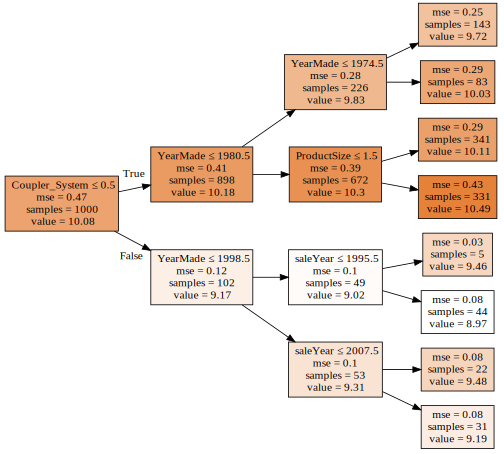

In [38]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2, ratio=0.9, size=7)

In [39]:
def predict(self, x): return np.array([self.predict_row(xi) for xi in x])
DecisionTree.predict = predict

In [41]:
def predict_row(self, xi):
    if self.is_leaf: return self.val
    t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
    return t.predict_row(xi)

DecisionTree.predict_row = predict_row

In [42]:
%time preds = tree.predict(X_valid[cols].values)

CPU times: user 87.3 ms, sys: 3.12 ms, total: 90.4 ms
Wall time: 89.8 ms


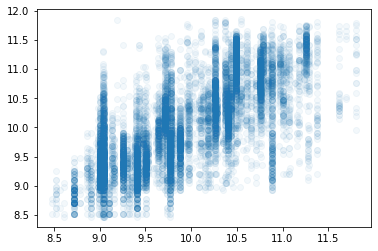

In [43]:
plt.scatter(preds, y_valid, alpha=0.05)

In [44]:
metrics.r2_score(preds, y_valid)

0.3077322755494807

CPU times: user 5 ms, sys: 952 µs, total: 5.95 ms
Wall time: 5.15 ms


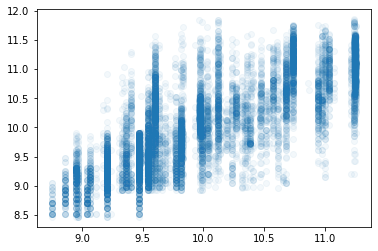

In [45]:
m = RandomForestRegressor(n_estimators=1, min_samples_leaf=5, bootstrap=False)
%time m.fit(x_samp, y_samp)
preds = m.predict(X_valid[cols].values)
plt.scatter(preds, y_valid, alpha=0.05)

In [46]:
metrics.r2_score(preds, y_valid)

0.47541053100694797

# Putting it together

In [47]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], 
                    idxs=np.array(range(self.sample_sz)), min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [48]:
class DecisionTree():
    def __init__(self, x, y, idxs, min_leaf=5):
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [49]:
ens = TreeEnsemble(X_train[cols], y_train, 5, 1000)

In [50]:
preds = ens.predict(X_valid[cols].values)

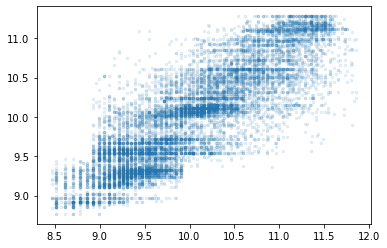

In [51]:
plt.scatter(y_valid, preds, alpha=0.1, s=6);

In [52]:
metrics.r2_score(y_valid, preds)

0.7101174157107124